# Requirements

In [ ]:
#requirements
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 148.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 138.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 132.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# Apply temperature scaling for each partition

In [ ]:
from dataset_loader import Dataset_loader_TE
import pandas as pd
from model_evaluator_temperature import Whisper_Evaluator
from whisper_trainer import Whisper_Builder
import torch

def results(param):
  '''
  Function to apply temperature scaling
  '''

  data_loader = Dataset_loader_TE()
  list_rows = []
  save_wers=[]
  save_certainties=[]
  transcript=[]
  gt=[]
  for partition_number  in range(1, 11):
    #load the data
    #dataset_training = data_loader.load_dataset_raw_uq(partition_type = "fine-tune", partition = partition_number)
    dataset_test = data_loader.load_dataset_raw_uq(partition_type = "test", partition = partition_number)
    #fetch the pre-trained model
    model_builder = Whisper_Builder()
    model = model_builder.model
    #build the evaluator
    processor = model_builder.processor
    sampling_rate = model_builder.sampling_rate
    whisper_evaluator_temperature= Whisper_Evaluator(model, processor, temperature=param, sampling_rate = sampling_rate)
    #evaluate with the test data
    print("dataset_test ", dataset_test)
    transcriptions_list, gt_list, certanties_tensor = whisper_evaluator_temperature.transcribe_dataset(dataset_test)

    # change to uncertainty
    certanties_tensor=1-certanties_tensor

    # save results
    save_certainties.append(certanties_tensor)
    transcript.append(transcriptions_list)
    gt.append(gt_list)

    # save wers
    wer_list = whisper_evaluator_temperature.compute_wers(gt_list, transcriptions_list)
    avg_wer =  sum(wer_list)/len(wer_list)
    std_wer = torch.tensor(wer_list).std()
    corr=whisper_evaluator_temperature.compute_ece(certanties_tensor,  wer_list )
    row_dictionary = {"partition": partition_number, "wer mean:": avg_wer, "wer std:": std_wer, "r": corr}
    list_rows += [row_dictionary]
    save_wers.append(wer_list)

  data_frame_test_wer = pd.DataFrame(list_rows)
  print(data_frame_test_wer)
  return data_frame_test_wer, save_wers, save_certainties, transcript, gt


In [ ]:
#Apply function with differents parameters of temperature scaling


#Values of temperature scaling
listTemperature=[0.10, 0.25, 0.50, 0.75, 1.0, 1.25, 2.0, 4.0]
# list to save results
save_wers_of_save_wers=[]
save_certainties_of_save_certainties=[]
data_frame_test_wer_joint=[]
# Execute function for each temperature value
for temp in listTemperature:
  data_frame_test_wer, save_wers, save_certainties, transcript, gt=results(param=temp)
  data_frame_test_wer['temperature']=temp
  data_frame_test_wer_joint.append(data_frame_test_wer)
  save_wers_of_save_wers.append( save_wers)
  save_certainties_of_save_certainties.append(save_certainties)

Fetching 73 files:   0%|          | 0/73 [00:00<?, ?it/s]

path_downloaded  /root/.cache/huggingface/hub/datasets--saul1917--SpaTrans_UQ_Bench_raw/snapshots/7beccd487d50b03682d8cf106d1f4899cb037c02
Using cuda device
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
dataset_test  Dataset({
    features: ['sentence', 'audio'],
    num_rows: 120
})
   partition  wer mean:        wer std:         r
0          1   0.280099  tensor(0.3790)  0.435417


# Generate plot for the best partition and the best temperature parameter

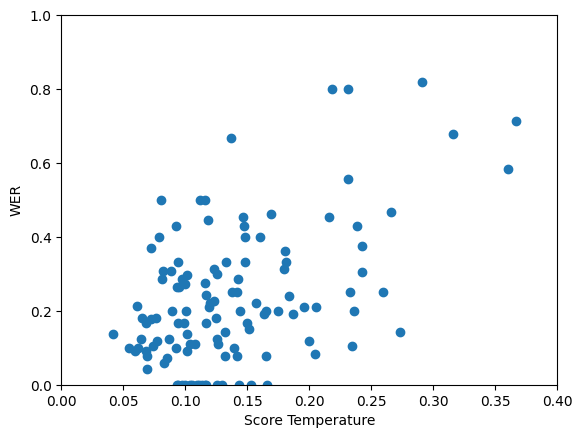

In [15]:


!pip install tikzplotlib
!pip install webcolors==1.11.1
import tikzplotlib
import pandas as pd
import matplotlib.pyplot as plt


# Create dataset with the best temperature parameter and the best partition. It is the first the parameter in [4] and the partition is the number [1]
yaxes=np.array(save_certainties_of_save_certainties[4][1])
xaxes=np.array(save_wers_of_save_wers[4][1])
data=pd.DataFrame(np.hstack((yaxes.reshape(-1,1), xaxes.reshape(-1,1))))
data.columns=['Score_temperature', 'WER']



# Create scatter plot
plt.scatter(data['WER'], data['Score_temperature'])
plt.xlabel('WER')
plt.ylabel('UQ Score Temperature')

plt.ylim(0,0.40)
plt.xlim(0,1.0)

# Save plot using tikz
tikzplotlib.save("scatter_plot_te.tikz")

# Show plot
plt.show()


